In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.preprocessing import image

In [2]:
image_dir = Path('Food Classification')

**Creating file dataframe**

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
#using glob to target particular image files

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
#separating the class names from the file paths and saving in labels

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(130, random_state=1))
#concatenate category samples
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
#sample 100% of the data again after shuffling



In [4]:
image_df['Label'].value_counts()

Label
chai             130
pav_bhaji        130
idli             130
kadai_paneer     130
pizza            130
fried_rice       130
masala_dosa      130
burger           130
chole_bhature    130
kulfi            130
momos            130
samosa           130
chapati          130
jalebi           130
paani_puri       130
pakode           130
dhokla           130
dal_makhani      130
kaathi_rolls     130
butter_naan      130
Name: count, dtype: int64

**train-test split**

In [5]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
#70% training 30% test
#since we are shuffling, random state = 1

**creating generators**

In [6]:
#limited memory so we train in batches to recycle memory
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [7]:
#this train_images will be passed into our fit function
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
#default image size for mobilenetV2 is 224x224
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
#shuffle after each epoch
    seed=42,
    subset='training'
#only available if validation_split is used to specify whether to use validation subset 0.2 or training subset

)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


**modeling**

In [8]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
#we dont wanna keep the classification layer of the og dataset on which the model is pretrained we just want our dataset's classification layer
#originally trained on imagenet  dataset 1000 classes
    weights='imagenet',
#to keep the same weights
    pooling='avg'
#output is 1d now
)

pretrained_model.trainable = False
#to not change the original imagenet weights
#We are transfering learning of the model so we keep it as it is
#This model is good for feature extraction
#Use the same model, remove the top layer, use your own top layer i.e. classes, dataset



9406464/9406464 [==============================] - 1s 0us/step


In [9]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#128 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)
#classification layer
model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

**training**

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    #as classes are encoded as vectors by the generator so we use categorical_crossentropy
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    #INCREASE NO. OF EPOCHS TO INCREASE ACCURACY (77.46% ACCURACY ACHIEVED ON 100 EPOCHS)
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='validation_loss',
            patience=3,
            #when validation loss stops improving for 3 consecutive epochs training will be stopped and best epochs weights are restored
            restore_best_weights=True
        )
    ]
)


Epoch 1/10


46/46 [==============================] - 71s 1s/step - loss: 2.0154 - accuracy: 0.4375 - val_loss: 1.1700 - val_accuracy: 0.6253
Epoch 2/10
46/46 [==============================] - 53s 1s/step - loss: 0.7535 - accuracy: 0.7740 - val_loss: 0.9137 - val_accuracy: 0.7190
Epoch 3/10
46/46 [==============================] - 55s 1s/step - loss: 0.4053 - accuracy: 0.8963 - val_loss: 0.8749 - val_accuracy: 0.7273
Epoch 4/10
46/46 [==============================] - 55s 1s/step - loss: 0.2301 - accuracy: 0.9444 - val_loss: 0.8317 - val_accuracy: 0.7521
Epoch 5/10
46/46 [==============================] - 57s 1s/step - loss: 0.1390 - accuracy: 0.9746 - val_loss: 0.7872 - val_accuracy: 0.7631
Epoch 6/10
46/46 [==============================] - 57s 1s/step - loss: 0.0770 - accuracy: 0.9918 - val_loss: 0.7948 - val_accuracy: 0.7493
Epoch 7/10
46/46 [==============================] - 54s 1s/step - loss: 0.0388 - accuracy: 0.9986 - val_loss: 0.7848 - val_accuracy: 0.7741
Epoch 8/10
46/46 

**results**

In [11]:
# model.save('food_classification.h5')
results = model.evaluate(test_images, verbose=0)
#gives loss and accuracy for test set
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 79.39%


**predictions**

In [12]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

25/25 [==============================] - 26s 980ms/step


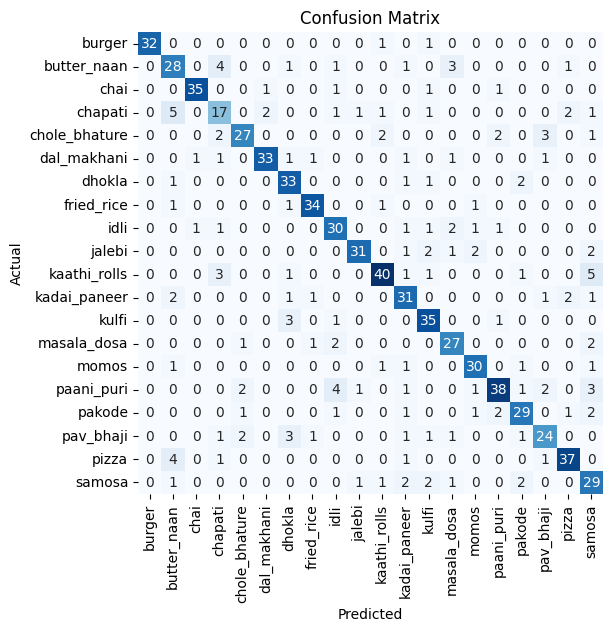

In [13]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       1.00      0.94      0.97        34
  butter_naan       0.65      0.72      0.68        39
         chai       0.95      0.90      0.92        39
      chapati       0.57      0.55      0.56        31
chole_bhature       0.82      0.73      0.77        37
  dal_makhani       0.92      0.82      0.87        40
       dhokla       0.75      0.87      0.80        38
   fried_rice       0.89      0.89      0.89        38
         idli       0.73      0.79      0.76        38
       jalebi       0.91      0.79      0.85        39
 kaathi_rolls       0.85      0.77      0.81        52
 kadai_paneer       0.70      0.79      0.75        39
        kulfi       0.76      0.88      0.81        40
  masala_dosa       0.75      0.82      0.78        33
        momos       0.83      0.86      0.85        35
   paani_puri       0.84      0.72      0.78        53
       pakode    

In [20]:
import cv2
# Replace this list with your actual class labels used during training
class_labels = image_df['Label']
img=cv2.imread('010.jpg')
img= cv2.resize(img, (224,224))
def preprocess_image(img):
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

img=preprocess_image(img)
predictions=model.predict(img)
print(class_labels[np.argmax(predictions)])
print(class_labels)


1/1 [==============================] - 0s 59ms/step
chai
0               chai
1          pav_bhaji
2       kaathi_rolls
3        dal_makhani
4          pav_bhaji
            ...     
2595      fried_rice
2596          dhokla
2597            idli
2598     butter_naan
2599            idli
Name: Label, Length: 2600, dtype: object


In [30]:
# Exporting Class labels
import pandas as pd
df=pd.DataFrame(class_labels)
label=df['Label']
label

In [31]:
model.save('final_food_classifier.h5')

c:\Users\HP\anaconda3\envs\nen\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
